# SI

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
from matplotlib import style
import warnings
import splitfolders 
from pathlib import Path


from PIL import Image, ImageFont, ImageDraw 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import cv2

### Global Settings

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
style.use("ggplot")
SEED = 42
TEST_SIZE = 0.2
BATCH_SIZE = 500
np.random.seed(seed=SEED)

## Entendimiento

In [3]:
df = pd.read_csv("./dataset.csv")

### Preprocesamiento de datos

In [45]:
splitfolders.ratio('./data', output="./out", seed=SEED, ratio=(0.6, 0.2,0.2))

Copying files: 15275 files [01:49, 138.89 files/s]


### Desarrollando el modelo

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, InputLayer, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [4]:
train_path = "./out/train"
test_path = "./out/test"
valid_path = "./out/val"

train_batches = ImageDataGenerator( 
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.2,1.0],
    horizontal_flip=True
    ).flow_from_directory(
        directory=train_path, 
        target_size=(224,224),
        batch_size=20)

test_batches = ImageDataGenerator( rescale=1./255 ).flow_from_directory(
    directory=test_path, 
    target_size=(224,224),
    batch_size=20)

valid_batches = ImageDataGenerator( rescale=1./255 ).flow_from_directory(
    directory=valid_path, 
    target_size=(224,224), 
    batch_size=20)

Found 9164 images belonging to 3 classes.
Found 3057 images belonging to 3 classes.
Found 3054 images belonging to 3 classes.


In [5]:
base_model = keras.applications.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    classifier_activation = 'sigmoid')

In [6]:
#base_model = tf.keras.applications.MobileNetV2(
#    include_top = False,
#    weights = 'imagenet',
#    input_shape = (224,224,3),
#    classifier_activation = 'sigmoid')

In [7]:
# base_model.trainable = False

In [8]:
# base_model.summary()

from sklearn.utils import class_weight
import numpy as np
import math

y_train = train_batches.labels

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 13.45668135095448, 1: 0.5752667922159448, 2: 0.8422020034923261}

In [9]:
# v.1
# max_poling_2d()
# conv2d(256, (1,1))
# Normalization
# Flatten
# Dropout(0.2)
# Dense(500)
# Dropout(0.2)
# Dense(120)
# Dropout(0.2)
# Dense(3,"softmax")
# optimizer = keras.optimizers.Adam(learning_rate=0.0005)


# v.2
# model = Sequential([
#    base_model,
#    tf.keras.layers.GlobalAveragePooling2D(),
#    Dense(3, "softmax")
#])
# optimizer = keras.optimizers.Adam(learning_rate=0.001)


In [10]:
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dropout(0.25),
    Dense(3, "softmax")
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________


In [12]:
#optimizer = keras.optimizers.Adam(learning_rate=0.0008
optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-3, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
callback = keras.callbacks.ModelCheckpoint(
                    filepath='./models/model-balance.{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}',
                    monitor='val_loss', 
                    verbose=1, 
                    save_best_only=True,
                    mode='auto')

In [14]:
history = model.fit(
    train_batches,
    validation_data=valid_batches, 
    epochs = 30, 
    steps_per_epoch = 100, 
    verbose = 1,
    class_weight=class_weight_dict,
    callbacks=[callback])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
100/100 [==============================] - 1249s 12s/step - loss: 0.9528 - accuracy: 0.5540 - val_loss: 0.7060 - val_accuracy: 0.7672

Epoch 00001: val_loss improved from inf to 0.70603, saving model to ./models/model-balance.01-0.71-0.77
INFO:tensorflow:Assets written to: ./models/model-balance.01-0.71-0.77/assets
Epoch 2/30
100/100 [==============================] - 1235s 12s/step - loss: 0.7279 - accuracy: 0.7030 - val_loss: 0.5093 - val_accuracy: 0.8418

Epoch 00002: val_loss improved from 0.70603 to 0.50933, saving model to ./models/model-balance.02-0.51-0.84
INFO:tensorflow:Assets written to: ./models/model-balance.02-0.51-0.84/assets
Epoch 3/30
100/100 [==============================] - 1231s 12s/step - loss: 0.5466 - accuracy: 0.7812 - val_loss: 0.6859 - val_accuracy: 0.7236

Epoch 00003: val_loss did not improve from 0.50933
Epoch

In [15]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

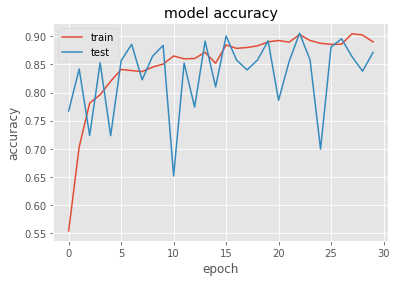

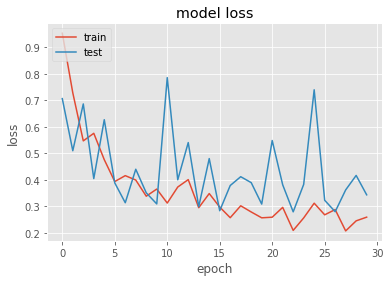

In [16]:
plot_accuracy(history)

In [17]:
testLoss, testAccuracy = model.evaluate(test_batches, verbose = 1)

print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))

153/153 [==============================] - 319s 2s/step - loss: 0.3096 - accuracy: 0.8842
Accuracy of model : 88.42 %
Loss of model : 0.3096


In [18]:
model.save("./models/model-v.2-{}.h5".format(str(round(testAccuracy,4)*100) + ' %'))

### Analizando el modelo

In [4]:
model = load_model("./models/weights.31-0.23.hdf5")

ValueError: No model found in config file.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 1536)        0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 2, 2, 256)         393472    
_________________________________________________________________
batch_normalization_203 (Bat (None, 2, 2, 256)         1024      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1025000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0

In [12]:
testLoss, testAccuracy = model.evaluate(test_batches, verbose = 1)

print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))

152/152 [==============================] - 373s 2s/step - loss: 0.2521 - accuracy: 0.9080
Accuracy of model : 90.8 %
Loss of model : 0.2521


In [ ]:
model = keras.load